___

# 5. Reproducibility Notebook
**A single clean notebook that automatically runs the final evaluation on the submitted test set and generates key metrics.**


--- Loading and Preprocessing Data ---


Saving Philippines-News-Headlines-Dataset-for-Sentiment-Analysis.csv to Philippines-News-Headlines-Dataset-for-Sentiment-Analysis (1).csv
Loaded dataset with 2000 training and 500 evaluation samples.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenization complete!
TRAINING WITH SPECIFIED HYPERPARAMETERS

Experiment Configuration:
----------------------------------------------------------------------
  Experiment_type......................... RandomSearch
  trial_number............................ 2
  learning_rate........................... 3e-05
  per_device_train_batch_size............. 8
  weight_decay............................ 0.1
  num_train_epochs........................ 4
  warmup_steps............................ 200
----------------------------------------------------------------------


Initializing model...


/tmp/ipython-input-1049177293.py:138: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.706000,0.406236,0.860000,0.850631
2,0.419900,0.124024,0.970000,0.970412
3,0.208600,0.036861,0.994000,0.994000
4,0.052500,0.028975,0.994000,0.994000



TRAINING COMPLETE

📊 Training Metrics:
----------------------------------------------------------------------
  train_runtime........................... 128.764500
  train_samples_per_second................ 62.129000
  train_steps_per_second.................. 7.766000
  total_flos.............................. 106877492510544.000000
  train_loss.............................. 0.450129
  epoch................................... 4.000000


🔍 Evaluating on test set...



📈 Evaluation Results:
----------------------------------------------------------------------
  eval_loss............................... 0.036861
  eval_accuracy........................... 0.994000
  eval_f1................................. 0.994000
  eval_runtime............................ 0.948900
  eval_samples_per_second................. 526.934000
  eval_steps_per_second................... 33.724000
  epoch................................... 4.000000


📊 Creating visualizations...


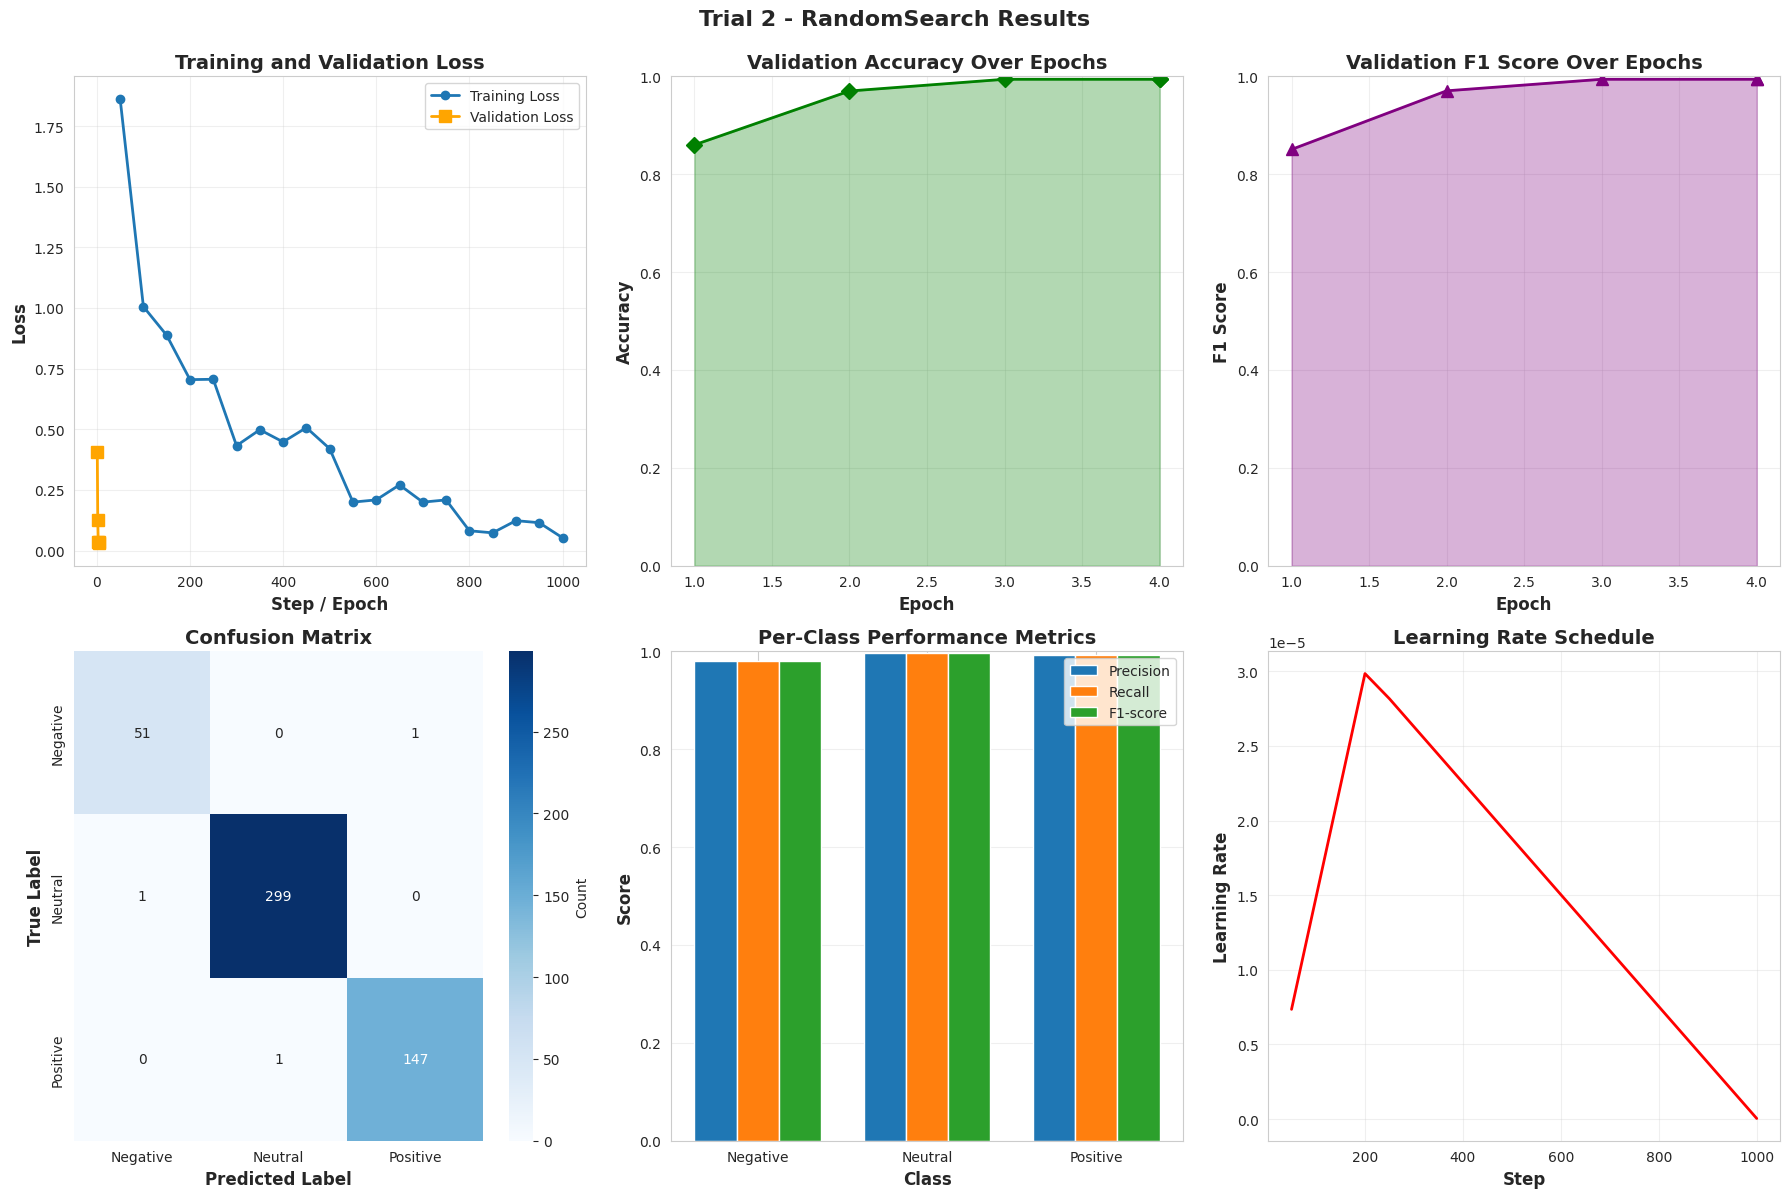



📋 Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98        52
     Neutral       1.00      1.00      1.00       300
    Positive       0.99      0.99      0.99       148

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500


📊 Summary Statistics:
              Metric  Score
            Accuracy  0.994
 F1 Score (Weighted)  0.994
Precision (Weighted)  0.994
   Recall (Weighted)  0.994

✅ Results saved to: trial_2_results.csv
✅ Visualization saved to: trial_2_visualization.png

EXPERIMENT COMPLETE


In [ ]:
# --- 6. TRAINING WITH SPECIFIED HYPERPARAMETERS AND VISUALIZATION ---

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import numpy as np
import pandas as pd
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer
import torch
from datasets import Dataset
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from google.colab import files

def model_init():
    model_checkpoint = "ProsusAI/finbert"
    num_labels = 3
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

# Define compute_metrics function
# This function computes and returns metrics for evaluation.
def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, predictions),
        'f1': f1_score(p.label_ids, predictions, average='weighted'),
    }

# --- 2. DATA PREPARATION (LIMITED SUBSET) ---

print("\n--- Loading and Preprocessing Data ---")
uploaded = files.upload()

df = pd.read_csv('Philippines-News-Headlines-Dataset-for-Sentiment-Analysis.csv')

nltk.download('vader_lexicon', quiet=True)
sia = SentimentIntensityAnalyzer()

def vader_label(score):
    if score >= 0.05:
        return 2 # Positive
    elif score <= -0.05:
        return 0 # Negative
    else:
        return 1 # Neutral

df['sentiment_score'] = df['Headlines'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
df['label'] = df['sentiment_score'].apply(vader_label)

texts = df['Headlines'].tolist()
labels = df['label'].tolist()
dataset = Dataset.from_dict({"text": texts, "label": labels})

# Create a limited subset for training and evaluation for demonstration
train_data = dataset.select(range(2000)) # Using first 2000 samples for training
eval_data = dataset.select(range(500))  # Using next 500 samples for evaluation

print(f"Loaded dataset with {len(train_data)} training and {len(eval_data)} evaluation samples.")

# Initialize Tokenizer
MODEL_NAME = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_eval = eval_data.map(tokenize_function, batched=True)

tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_eval = tokenized_eval.rename_column("label", "labels")

tokenized_train.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
tokenized_eval.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])

print("Tokenization complete!")


# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("=" * 70)
print("TRAINING WITH SPECIFIED HYPERPARAMETERS")
print("=" * 70)

# Experiment Configuration
experiment_config = {
    "Experiment_type": "RandomSearch",
    "trial_number": 2,
    "learning_rate": 0.00003,
    "per_device_train_batch_size": 8,
    "weight_decay": 0.1,
    "num_train_epochs": 4,
    "warmup_steps": 200
}

print("\nExperiment Configuration:")
print("-" * 70)
for key, value in experiment_config.items():
    print(f"  {key:.<40} {value}")
print("-" * 70)

# Create Training Arguments with specified hyperparameters
training_args = TrainingArguments(
    output_dir=f"./trial_{experiment_config['trial_number']}_results",
    learning_rate=experiment_config["learning_rate"],
    per_device_train_batch_size=experiment_config["per_device_train_batch_size"],
    per_device_eval_batch_size=16,
    weight_decay=experiment_config["weight_decay"],
    num_train_epochs=experiment_config["num_train_epochs"],
    warmup_steps=experiment_config["warmup_steps"],
    # Evaluation and logging settings
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=torch.cuda.is_available(),
    report_to="none",
    save_total_limit=2,
)

# Initialize fresh model
print("\n\nInitializing model...")
model = model_init()

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

print("Starting training...")
print("=" * 70)

# Train the model
train_result = trainer.train()

print("\n" + "=" * 70)
print("TRAINING COMPLETE")
print("=" * 70)

# Get training metrics
training_metrics = train_result.metrics
print("\n📊 Training Metrics:")
print("-" * 70)
for key, value in training_metrics.items():
    print(f"  {key:.<40} {value:.6f}")

# Evaluate on test set
print("\n\n🔍 Evaluating on test set...")
eval_results = trainer.evaluate()

print("\n📈 Evaluation Results:")
print("-" * 70)
for key, value in eval_results.items():
    print(f"  {key:.<40} {value:.6f}")
print("=" * 70)

# --- VISUALIZATIONS ---

# 1. Extract training history
history_df = pd.DataFrame(trainer.state.log_history)

# Separate training and evaluation logs
train_logs = history_df[history_df['loss'].notna()].copy()
eval_logs = history_df[history_df['eval_loss'].notna()].copy()

print("\n\n📊 Creating visualizations...")

# Create figure with subplots
fig = plt.figure(figsize=(18, 12))

# 1. Training and Validation Loss
ax1 = plt.subplot(2, 3, 1)
if not train_logs.empty:
    ax1.plot(train_logs['step'], train_logs['loss'],
             marker='o', label='Training Loss', linewidth=2, markersize=6)
if not eval_logs.empty:
    ax1.plot(eval_logs['epoch'], eval_logs['eval_loss'],
             marker='s', label='Validation Loss', linewidth=2, markersize=8, color='orange')
ax1.set_xlabel('Step / Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Validation Accuracy Over Epochs
ax2 = plt.subplot(2, 3, 2)
if not eval_logs.empty and 'eval_accuracy' in eval_logs.columns:
    ax2.plot(eval_logs['epoch'], eval_logs['eval_accuracy'],
             marker='D', color='green', linewidth=2, markersize=8)
    ax2.fill_between(eval_logs['epoch'], eval_logs['eval_accuracy'],
                      alpha=0.3, color='green')
ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Validation Accuracy Over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

# 3. Validation F1 Score Over Epochs
ax3 = plt.subplot(2, 3, 3)
if not eval_logs.empty and 'eval_f1' in eval_logs.columns:
    ax3.plot(eval_logs['epoch'], eval_logs['eval_f1'],
             marker='^', color='purple', linewidth=2, markersize=8)
    ax3.fill_between(eval_logs['epoch'], eval_logs['eval_f1'],
                      alpha=0.3, color='purple')
ax3.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax3.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax3.set_title('Validation F1 Score Over Epochs', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0, 1])

# 4. Get predictions for confusion matrix
predictions = trainer.predict(tokenized_eval)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Confusion Matrix
ax4 = plt.subplot(2, 3, 4)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            ax=ax4, cbar_kws={'label': 'Count'})
ax4.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax4.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax4.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# 5. Per-Class Metrics
ax5 = plt.subplot(2, 3, 5)
report = classification_report(y_true, y_pred,
                               target_names=['Negative', 'Neutral', 'Positive'],
                               output_dict=True)
classes = ['Negative', 'Neutral', 'Positive']
metrics = ['precision', 'recall', 'f1-score']
x = np.arange(len(classes))
width = 0.25

for i, metric in enumerate(metrics):
    values = [report[cls][metric] for cls in classes]
    ax5.bar(x + i*width, values, width, label=metric.capitalize())

ax5.set_xlabel('Class', fontsize=12, fontweight='bold')
ax5.set_ylabel('Score', fontsize=12, fontweight='bold')
ax5.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax5.set_xticks(x + width)
ax5.set_xticklabels(classes)
ax5.legend(fontsize=10)
ax5.set_ylim([0, 1])
ax5.grid(True, alpha=0.3, axis='y')

# 6. Learning Rate Schedule (if available)
ax6 = plt.subplot(2, 3, 6)
if 'learning_rate' in history_df.columns:
    lr_data = history_df[history_df['learning_rate'].notna()]
    if not lr_data.empty:
        ax6.plot(lr_data['step'], lr_data['learning_rate'],
                color='red', linewidth=2)
        ax6.set_xlabel('Step', fontsize=12, fontweight='bold')
        ax6.set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
        ax6.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax6.grid(True, alpha=0.3)
        ax6.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
else:
    # If LR schedule not available, show metrics summary
    metrics_summary = {
        'Accuracy': eval_results['eval_accuracy'],
        'F1 Score': eval_results['eval_f1'],
        'Training Loss': training_metrics['train_loss'],
        'Eval Loss': eval_results['eval_loss']
    }
    ax6.bar(range(len(metrics_summary)), list(metrics_summary.values()),
            color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    ax6.set_xticks(range(len(metrics_summary)))
    ax6.set_xticklabels(list(metrics_summary.keys()), rotation=45, ha='right')
    ax6.set_ylabel('Value', fontsize=12, fontweight='bold')
    ax6.set_title('Final Metrics Summary', fontsize=14, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Trial {experiment_config["trial_number"]} - {experiment_config["Experiment_type"]} Results',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(f'trial_{experiment_config["trial_number"]}_visualization.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Print detailed classification report
print("\n\n📋 Detailed Classification Report:")
print("=" * 70)
print(classification_report(y_true, y_pred,
                           target_names=['Negative', 'Neutral', 'Positive']))

# Create summary DataFrame
summary_data = {
    'Metric': ['Accuracy', 'F1 Score (Weighted)', 'Precision (Weighted)', 'Recall (Weighted)'],
    'Score': [
        report['accuracy'],
        report['weighted avg']['f1-score'],
        report['weighted avg']['precision'],
        report['weighted avg']['recall']
    ]
}
summary_df = pd.DataFrame(summary_data)

print("\n📊 Summary Statistics:")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

# Save results to CSV
results_dict = {
    **experiment_config,
    'final_accuracy': eval_results['eval_accuracy'],
    'final_f1': eval_results['eval_f1'],
    'final_loss': eval_results['eval_loss'],
    'train_loss': training_metrics['train_loss'],
    'train_runtime': training_metrics['train_runtime'],
    'train_samples_per_second': training_metrics['train_samples_per_second']
}

results_df = pd.DataFrame([results_dict])
results_df.to_csv(f'trial_{experiment_config["trial_number"]}_results.csv', index=False)

print(f"\n✅ Results saved to: trial_{experiment_config['trial_number']}_results.csv")
print(f"✅ Visualization saved to: trial_{experiment_config['trial_number']}_visualization.png")
print("\n" + "=" * 70)
print("EXPERIMENT COMPLETE")
print("=" * 70)